# Microtubule Tip Fitter

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage

data_dir = Path('/home/hadim/Drive/Data/Fake Microtubules/anamic/taper_length/')

../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [2]:
condition = "taper_length_nm-0000"
fnames = sorted(list((data_dir / condition).glob("*.tif")))

index = 49
fname = fnames[index]
print(fname)

# Open the image
image = tifffile.imread(str(fname))

# Load metadata
metadata = json.load(open(fname.with_suffix('.json')))

# Get microtubule tip coordinates
tip_start = np.array(metadata['tip_start'])
tip_end = np.array(metadata['tip_end'])

/home/hadim/Drive/Data/Fake Microtubules/anamic/taper_length/taper_length_nm-0000/microtubule_0049.tif


In [4]:
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 5  # pixel
args['get_thick_line_args']['line_thickness'] = 3000 / metadata['pixel_size']  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.15
args['perpendicular_line_fit_args']['continuous_discard'] = False

args['offset_start'] = 4000 / metadata['pixel_size']  # pixel
args['offset_end'] = 2000 / metadata['pixel_size']  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 400 / metadata["pixel_size"]  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

results = anamic.fitter.microtubule_tip_fitter(tip_start, tip_end, image, **args)
line_fit_tips, x_profile, y_profile, fit_result, fit_func = results
fit_values = fit_result.values
fit_values, fit_values['sigma'] * metadata['pixel_size']

({'mu': 37.2131827399218,
  'sigma': 0.9816900137362744,
  'mt': 0.1771294555875551,
  'bg': 0.7781869154984649},
 107.98590151099019)

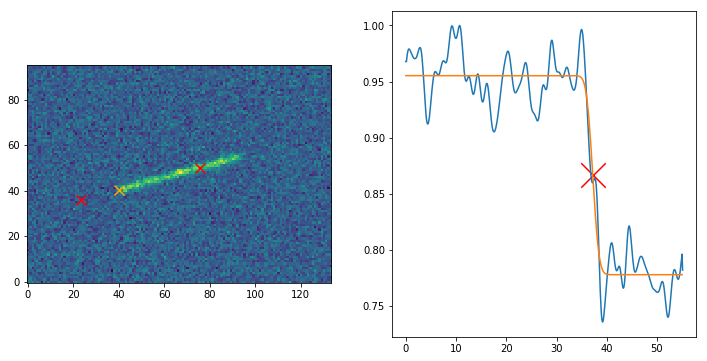

In [6]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax1.set_aspect('equal')
ax1.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

ax2.plot(x_profile, y_profile, label='data')
ax2.plot(x, y_fitted, label='fit')
mu = fit_values['mu']
ax2.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

vec = line_fit_tips[1] - line_fit_tips[0]
x, y = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
ax1.scatter(y, x, color='orange', s=100, marker='x')